In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Necessary Imports and Installations**

In [ ]:
!pip install contractions


In [ ]:
!pip install --upgrade numpy gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_ver

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from contractions import fix
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


## **Text Preprocessing, Tokenization, and Sequence Padding**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/truevsfakenews.csv')
df.head()

,text,label
0,WASHINGTON (Reuters) - The Republican and Demo...,true
1,Women should get as far away from Oklahoma as ...,fake
2,Another huge crowd of Americans tuned in last ...,fake
3,Donald Trump is desperate to stop the investig...,fake
4,"(Reuters) - Planned Parenthood, the U.S. medic...",true


### **Text Cleaning**

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Define contraction mapping
contraction_map = {
    "don't": "do not", "doesn't": "does not", "didn't": "did not", "can't": "cannot",
    "couldn't": "could not", "won't": "will not", "wouldn't": "would not", "shouldn't": "should not",
    "i'm": "i am", "it's": "it is", "he's": "he is", "she's": "she is", "that's": "that is",
    "what's": "what is", "there's": "there is", "isn't": "is not", "aren't": "are not"
}

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def expand_contractions(text, contraction_map):
    pattern = re.compile('(%s)' % '|'.join(re.escape(key) for key in contraction_map.keys()))
    return pattern.sub(lambda x: contraction_map[x.group()], text)

def clean_text(text):
    text = text.lower()
    text = expand_contractions(text, contraction_map)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'\@\w+|\#','', text)  # Remove mentions and hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove numbers and special characters
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply on DataFrame
df['clean_text'] = df['text'].apply(clean_text)
df['label'] = df['label'].map({'fake': 0, 'true': 1})
df[['text', 'clean_text']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,text,clean_text
0,WASHINGTON (Reuters) - The Republican and Demo...,washington reuters republican democratic leade...
1,Women should get as far away from Oklahoma as ...,woman get far away oklahoma soon possible chri...
2,Another huge crowd of Americans tuned in last ...,another huge crowd american tuned last week re...
3,Donald Trump is desperate to stop the investig...,donald trump desperate stop investigation dirt...
4,"(Reuters) - Planned Parenthood, the U.S. medic...",reuters planned parenthood u medical service p...


**Visualization**

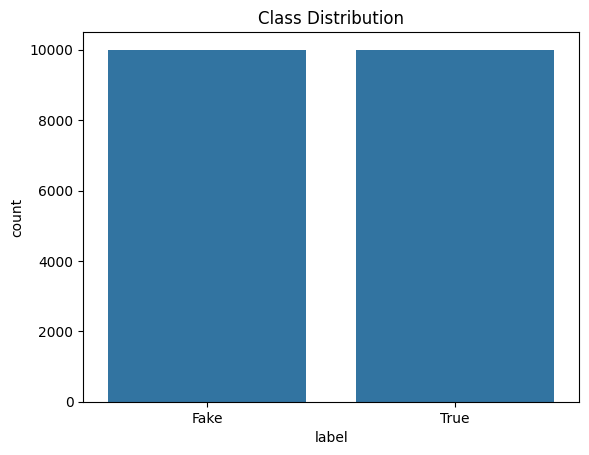

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='label')
plt.xticks([0, 1], ['Fake', 'True'])
plt.title('Class Distribution')
plt.show()


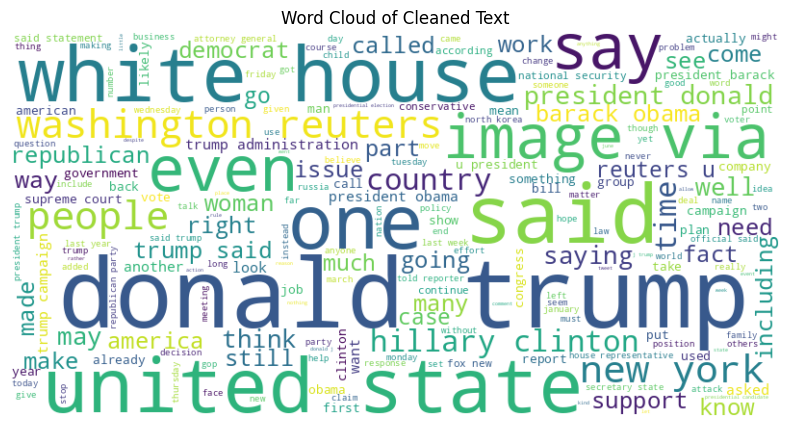

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = " ".join(df['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Text')
plt.show()


## **Model Builing and Training**

**Splitting into train and test**

In [ ]:
# 1. First Split - train vs. test (80% train, 20% test)
X_train_full, X_test, y_train_full, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

# 2. Second Split - train vs. validation (80% of 80% = 64% train, 16% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# 3. Tokenize and pad all sets
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Set maxlen to a reasonable length (e.g., 95th percentile of train)
maxlen = int(np.percentile([len(x) for x in X_train_seq], 95))

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

# Ensure labels are integers
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

**Simple RNN Model**

In [ ]:
from tensorflow.keras.layers import Dropout

# Build Simple RNN Model
model_rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen),  # Embedding layer
    SimpleRNN(128),  # Simple RNN layer
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile the model
model_rnn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [ ]:

# Early stopping to avoid overfitting
es = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)


In [ ]:
import time

start_time_rnn = time.time()

# Train the model
history_rnn = model_rnn.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[es])


rnn_train_time = time.time() - start_time_rnn

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.5059 - loss: 0.7063 - val_accuracy: 0.5444 - val_loss: 0.6876
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.5812 - loss: 0.6838 - val_accuracy: 0.7422 - val_loss: 0.5542
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7314 - loss: 0.5836 - val_accuracy: 0.7425 - val_loss: 0.5478
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.7463 - loss: 0.5597 - val_accuracy: 0.7400 - val_loss: 0.5378
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.7524 - loss: 0.5521 - val_accuracy: 0.7441 - val_loss: 0.5363
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.7563 - loss: 0.5384 - val_accuracy: 0.7584 - val_loss: 0.5307
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.7672 - loss: 0.5295 - val_accuracy: 0.7628 - val_loss: 0.5252
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.7817 - loss: 0.5133 - val_a

**Evaluation Metrics**

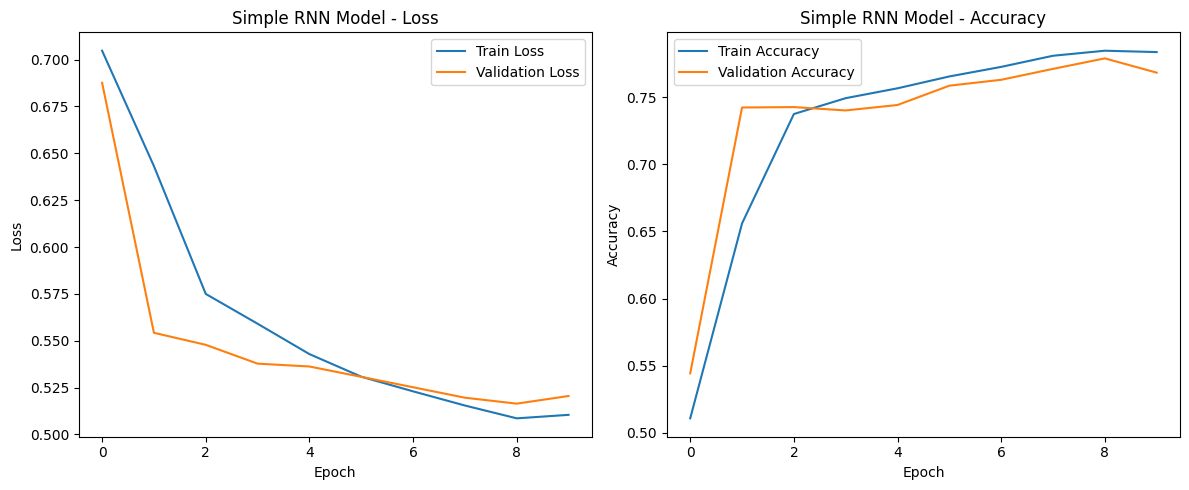

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training history (loss and accuracy)
def plot_history(history, title):
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)  # Plot loss in the first subplot
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)  # Plot accuracy in the second subplot
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history of the Simple RNN model
plot_history(history_rnn, "Simple RNN Model")



**LSTM Model**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Build LSTM Model
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen),  # Embedding layer
    LSTM(64),  # LSTM layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

In [ ]:

# Compile the model
model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])


In [ ]:

# Early stopping to avoid overfitting (Monitor 'val_loss')
es = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)


In [ ]:
start_time_lstm = time.time()

# Train the model with early stopping
history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[es])

lstm_train_time = time.time() - start_time_lstm

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.5253 - loss: 0.6888 - val_accuracy: 0.5459 - val_loss: 0.6684
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5332 - loss: 0.6677 - val_accuracy: 0.5497 - val_loss: 0.6621
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5371 - loss: 0.6595 - val_accuracy: 0.9275 - val_loss: 0.3084
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9423 - loss: 0.2135 - val_accuracy: 0.9847 - val_loss: 0.0673
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9857 - loss: 0.0640 - val_accuracy: 0.9850 - val_loss: 0.0649
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9918 - loss: 0.0350 - val_accuracy: 0.9734 - val_loss: 0.1103
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9947 - loss: 0.0284 - val_accuracy: 0.9794 - val_loss: 0.0889
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9983 - loss: 0.0100 - val_ac

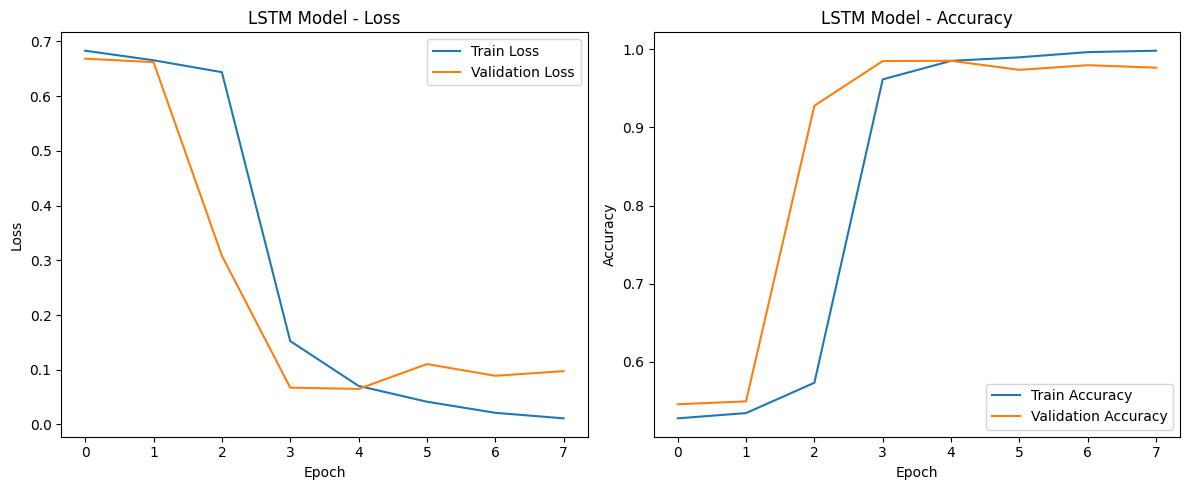

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training history (loss and accuracy)
def plot_history(history, title):
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)  # Plot loss in the first subplot
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)  # Plot accuracy in the second subplot
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history of the LSTM model
plot_history(history_lstm, "LSTM Model")


**LSTM with pretrained Word2Vec embeddings**

In [ ]:
import gensim.downloader as api
from gensim.models import Word2Vec
from tensorflow.keras.layers import Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Load pre-trained Word2Vec embeddings
w2v = api.load('word2vec-google-news-300')
embedding_dim = 300

# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill the embedding matrix with pre-trained word vectors
for word, i in tokenizer.word_index.items():
    if word in w2v:
        embedding_matrix[i] = w2v[word]


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:

# Build LSTM Model with Word2Vec embeddings
model_lstm_w2v = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True),  # Embedding layer with pre-trained weights (trainable)
    Bidirectional(LSTM(128, return_sequences=True)),  # Bidirectional LSTM layer
    Dropout(0.5),  # Dropout layer to avoid overfitting
    LSTM(64),  # LSTM layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

**Model Compilation and Training**

In [ ]:
# Compile the model with a learning rate scheduler
optimizer = Adam(learning_rate=0.001)  # Adam optimizer with a learning rate
model_lstm_w2v.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

In [ ]:
# Early stopping to avoid overfitting
es = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)


In [ ]:
start_time_w2v = time.time()

# Train the model with early stopping
history_lstm_w2v = model_lstm_w2v.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[es])

w2v_train_time = time.time() - start_time_w2v

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 27s 106ms/step - accuracy: 0.5257 - loss: 0.6895 - val_accuracy: 0.5528 - val_loss: 0.6667
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 105ms/step - accuracy: 0.5691 - loss: 0.6465 - val_accuracy: 0.9303 - val_loss: 0.3751
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.9390 - loss: 0.2367 - val_accuracy: 0.9450 - val_loss: 0.1862
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.9440 - loss: 0.1853 - val_accuracy: 0.9475 - val_loss: 0.1744
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 99ms/step - accuracy: 0.9492 - loss: 0.1716 - val_accuracy: 0.9459 - val_loss: 0.1773
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.9499 - loss: 0.1683 - val_accuracy: 0.9463 - val_loss: 0.1782
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - accuracy: 0.9518 - loss: 0.1628 - val_accuracy: 0.9456 - val_loss: 0.1788


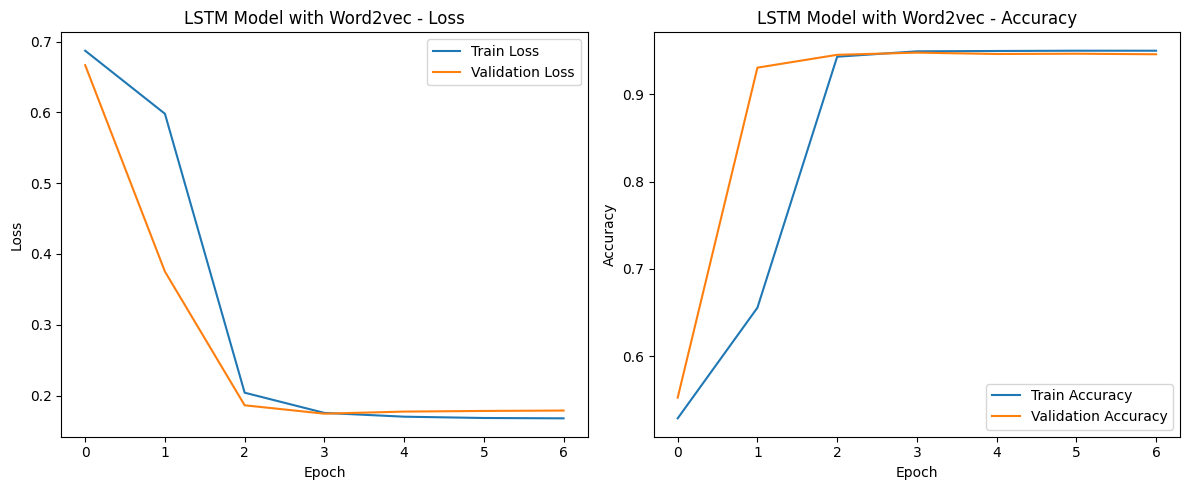

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training history (loss and accuracy)
def plot_history(history, title):
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)  # Plot loss in the first subplot
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)  # Plot accuracy in the second subplot
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history of the LSTM model
plot_history(history_lstm_w2v, "LSTM Model with Word2vec")


**Evaluation of the Models**

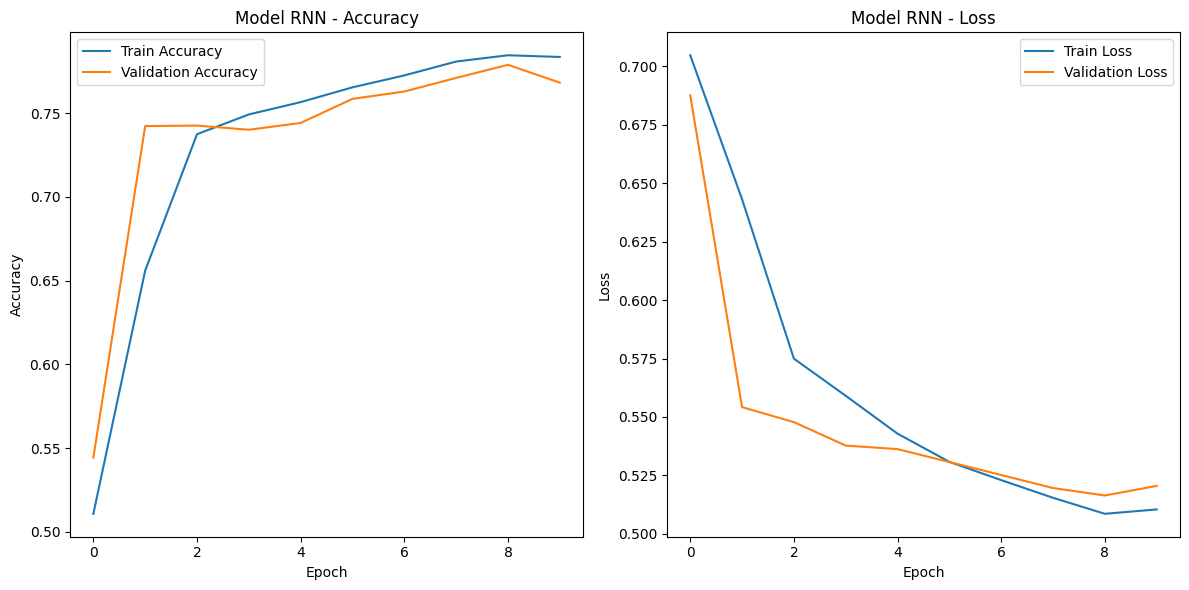

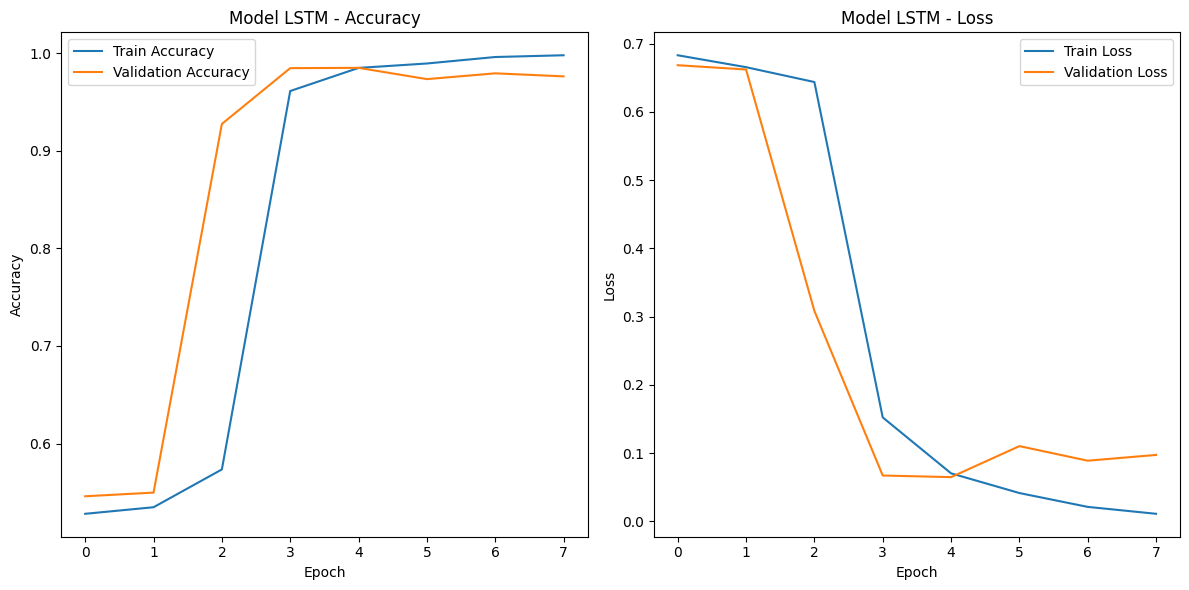

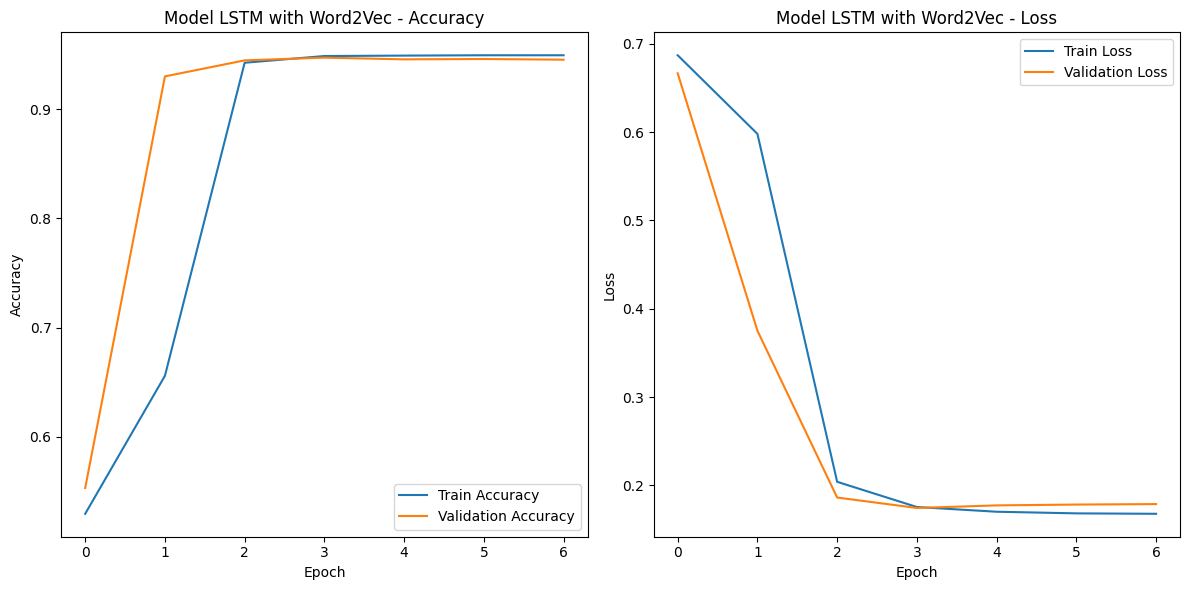

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    # Create a figure with 2 subplots side by side
    plt.figure(figsize=(12, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

# Plot training history for each model
plot_history(history_rnn, "Model RNN")
plot_history(history_lstm, "Model LSTM")
plot_history(history_lstm_w2v, "Model LSTM with Word2Vec")


In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    print(f"\n{model_name} Evaluation:")
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, X_test, y_test, name="Model"):
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()



Model RNN Evaluation:
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Accuracy: 0.781
Confusion Matrix:
 [[1534  521]
 [ 355 1590]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.75      0.78      2055
           1       0.75      0.82      0.78      1945

    accuracy                           0.78      4000
   macro avg       0.78      0.78      0.78      4000
weighted avg       0.78      0.78      0.78      4000

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


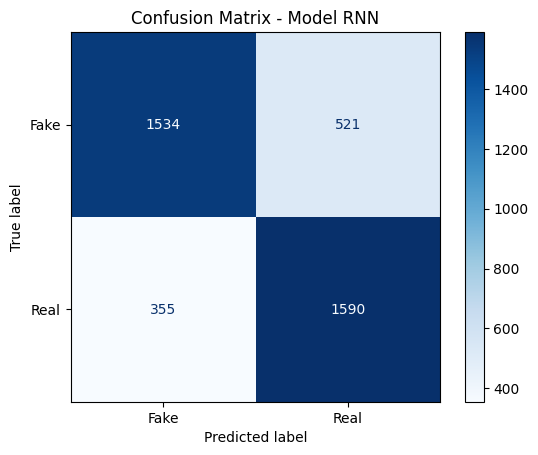

In [ ]:
# Evaluate all models
evaluate_model(model_rnn, X_test_pad, y_test, "Model RNN")
plot_confusion_matrix(model_rnn, X_test_pad, y_test, "Model RNN")


Model LSTM Evaluation:
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy: 0.99075
Confusion Matrix:
 [[2039   16]
 [  21 1924]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2055
           1       0.99      0.99      0.99      1945

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


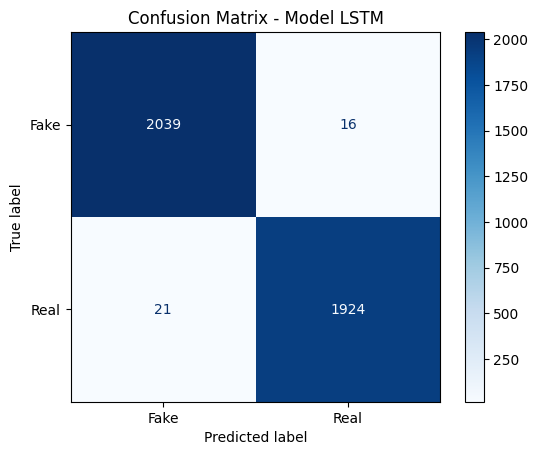

In [ ]:
evaluate_model(model_lstm, X_test_pad, y_test, "Model LSTM")
plot_confusion_matrix(model_lstm, X_test_pad, y_test, "Model LSTM")


Model LSTM with Word2Vec Evaluation:
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
Accuracy: 0.998
Confusion Matrix:
 [[2051    4]
 [   4 1941]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2055
           1       1.00      1.00      1.00      1945

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


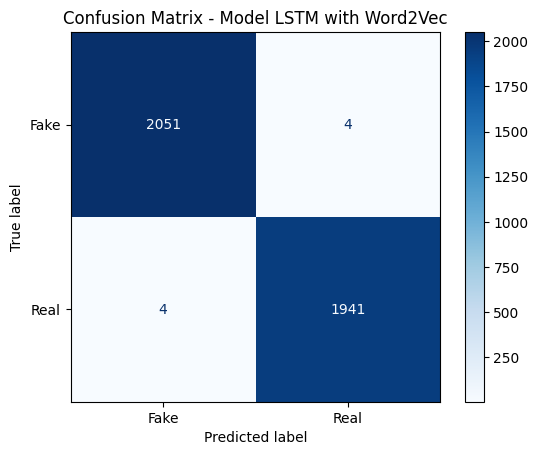

In [ ]:
evaluate_model(model_lstm_w2v, X_test_pad, y_test, "Model LSTM with Word2Vec")
plot_confusion_matrix(model_lstm_w2v, X_test_pad, y_test, "Model LSTM with Word2Vec")

RNN - Training Time: 101.68s | Final Loss: 0.5105
LSTM - Training Time: 58.84s | Final Loss: 0.0112
LSTM + Word2Vec - Training Time: 231.18s | Final Loss: 0.1678


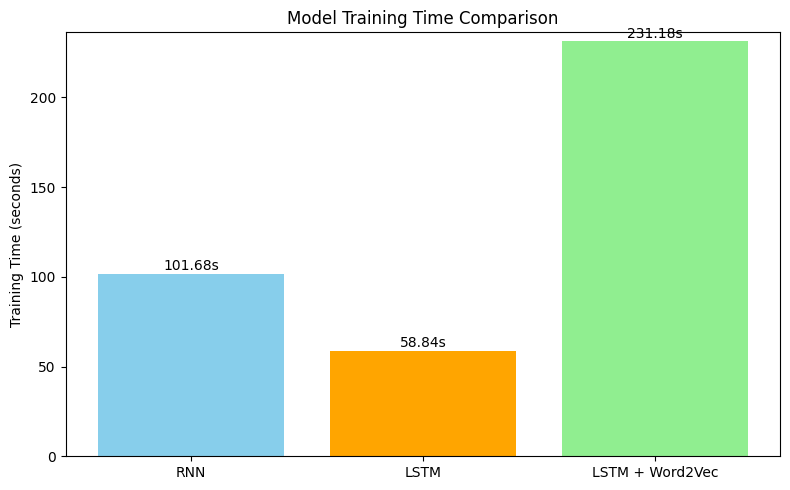

In [ ]:
rnn_final_loss = history_rnn.history['loss'][-1]
lstm_final_loss = history_lstm.history['loss'][-1]
w2v_final_loss = history_lstm_w2v.history['loss'][-1]

print(f"RNN - Training Time: {rnn_train_time:.2f}s | Final Loss: {rnn_final_loss:.4f}")
print(f"LSTM - Training Time: {lstm_train_time:.2f}s | Final Loss: {lstm_final_loss:.4f}")
print(f"LSTM + Word2Vec - Training Time: {w2v_train_time:.2f}s | Final Loss: {w2v_final_loss:.4f}")

import matplotlib.pyplot as plt

# Models and corresponding training time values
models = ['RNN', 'LSTM', 'LSTM + Word2Vec']
training_times = [rnn_train_time, lstm_train_time, w2v_train_time]

# Create the plot
plt.figure(figsize=(8, 5))
bars = plt.bar(models, training_times, color=['skyblue', 'orange', 'lightgreen'])

# Add labels and title
plt.ylabel('Training Time (seconds)')
plt.title('Model Training Time Comparison')

# Annotate each bar with its height
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.2, f'{height:.2f}s', ha='center', va='bottom')

# Add padding to y-axis for clear display
plt.ylim(0, max(training_times) + 5)

plt.tight_layout()
plt.show()


In [ ]:
# Check for GPU (for Colab)
gpu_info = tf.config.list_physical_devices('GPU')
print("GPU Available:", gpu_info if gpu_info else "No GPU detected")

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**GUI for Real Time Prediction**

In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.4 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import re
import string

# --- Your existing ML-related functions (unchanged) ---
def preprocess_input(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

def predict_news(text):
    cleaned = preprocess_input(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=maxlen, padding='post')
    pred = model_lstm.predict(padded)[0][0]
    label = "True News" if pred > 0.5 else "Fake News"
    confidence = round(float(pred if pred > 0.5 else 1 - pred) * 100, 2)
    return f"{label} ({confidence}% confidence)"

custom_css = """
html, body, .gradio-container {
    background-color: #ffffff !important;
    color: #000000 !important;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif !important;
    margin: 0;
    padding: 0;
    min-height: 100vh;
    display: flex;
    justify-content: center;
    align-items: flex-start;
    padding-top: 40px;
}

* {
    color: #000000 !important;
    box-sizing: border-box;
}

.title h1 {
    font-size: 2.8rem;
    font-weight: 700;
    margin-bottom: 0.3rem;
    color: #222222 !important;
    text-align: center;
}

.title p {
    font-size: 1.2rem;
    color: #555555 !important;
    margin-top: 0;
    text-align: center;
    font-weight: 500;
    margin-bottom: 2rem;
}

.textbox textarea, .textbox input {
    margin-top: 1rem;
    padding: 1rem;
    background: #fff9c4 !important;
    border-radius: 10px;
    font-size: 1.1rem;
    border: 1.5px solid #fdd835 !important;
    color: #000000 !important;
    box-shadow: 0 1px 5px rgba(0,0,0,0.1);
    transition: border-color 0.3s ease;
    width: 100%;
    resize: vertical;
    min-height: 180px;
}

.textbox textarea:focus, .textbox input:focus {
    border-color: #fbc02d !important;
    outline: none !important;
    box-shadow: 0 0 8px #fbc02d !important;
}

::placeholder {
    color: #666666 !important;
    font-style: italic;
}

.label-result, .label-result * {
    margin-top: 1.5rem;
    padding: 1rem 1.5rem;
    background: #fff9c4 !important;
    border-radius: 10px;
    font-size: 1.2rem;
    border: 1.5px solid #fdd835 !important;
    color: #000000 !important;
    font-weight: 700 !important;
    text-align: center !important;
    box-shadow: 0 2px 8px rgba(0,0,0,0.1);
    min-height: 56px;
    display: flex;
    justify-content: center;
    align-items: center;
}

.button-row {
    display: flex;
    justify-content: center;
    gap: 1rem;
    margin-top: 1.8rem;
}

.btn-detect, .btn-clear {
    padding: 0.8rem 2rem;
    font-size: 1.1rem;
    font-weight: 600;
    border-radius: 8px;
    border: none;
    cursor: pointer;
    transition: background-color 0.3s ease;
    box-shadow: 0 3px 6px rgba(0,0,0,0.15);
}

.btn-detect {
    background: #4caf50 !important;
    color: #ffffff !important;
}

.btn-detect:hover {
    background: #388e3c !important;
}

.btn-clear {
    background: #e0f2f1 !important;
    color: #000000 !important;
}

.btn-clear:hover {
    background: #b2dfdb !important;
}

.example-box {
    margin-top: 2rem;
    padding: 1.5rem;
    background: #fff9c4 !important;
    border-radius: 10px;
    font-size: 1rem;
    border: 1.5px solid #fdd835 !important;
    color: #000000 !important;
    box-shadow: 0 2px 8px rgba(0,0,0,0.1);
    max-width: 700px;
    margin-left: auto;
    margin-right: auto;
}

.gr-blocks {
    max-width: 700px;
    width: 90%;
    margin-left: auto;
    margin-right: auto;
    padding-bottom: 40px;
}
"""


# --- Gradio app UI ---
with gr.Blocks(css=custom_css, title="News Authenticity Analyzer") as demo:
    gr.Markdown("""
    <div class='title'>
        <h1>News Authenticity Analyzer</h1>
    </div>
    """)

    with gr.Group():
        news_input = gr.Textbox(
            label="Enter News Content",
            placeholder="Paste or type a news headline or paragraph...",
            lines=6,
            elem_classes=["textbox"]
        )

        with gr.Row(elem_classes=["button-row"]):
            predict_button = gr.Button("Analyze", elem_classes=["btn-detect"])
            clear_button = gr.Button("Clear", elem_classes=["btn-clear"])

        output_label = gr.Label(label="Prediction Result", elem_classes=["label-result"])

    gr.Markdown("""
    <div class='example-box'>
    <strong>Example:</strong><br>
    <em>"SHOCKING: Celebrity seen with alien in Times Square! Government covering up the truth about extraterrestrial visitors. Click NOW for exclusive photos!"</em><br><br>
    <strong>Result:</strong> Fake News (98.56% confidence)
    </div>
    """)

    gr.Examples(
        examples=[
            ["Scientists confirm breakthrough in renewable energy storage technology that could revolutionize the industry."],
            ["BREAKING: Aliens land in Times Square! Insider leaks government coverup. Click now!"],
            ["The Federal Reserve announced a 0.25% rate hike to control inflation."]
        ],
        inputs=news_input
    )

    gr.Markdown("<br><center><small>v1.0 | Built with AI and Gradio</small></center>")

    predict_button.click(fn=predict_news, inputs=news_input, outputs=output_label)
    clear_button.click(fn=lambda: ("", ""), outputs=[news_input, output_label])

demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9ebb75574ddba40c4b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
